In [1]:
### IMPORTING NECESSARY LIBRARIES

In [2]:
# IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import glob, os, shutil,random
import tensorflow as tf
import cv2

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
# IMPORTS
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense, BatchNormalization, Input, Lambda, Activation, Conv2D, MaxPooling2D, Reshape, Bidirectional, TimeDistributed, GRU
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### CREATING DATASET


In [4]:
# DIRECTORIES
DIRECTORY = '../input/mendeley-dataset/Initial_Dataset/'
TRAIN_DIR = os.path.join(DIRECTORY, 'train')
VAL_DIR = os.path.join(DIRECTORY, 'val')
TEST_DIR = os.path.join(DIRECTORY, 'test')


In [5]:
# HYPERPARAMETERS
learning_rate = 0.0001
BATCH_SIZE = 32
IMG_SIZE = (224,224)
INPUT_SHAPE = (224, 224, 3)

In [6]:
# ASSIGNING DATASET TO VARIABLE
TRAIN_IT = image_dataset_from_directory(TRAIN_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
VAL_IT = image_dataset_from_directory(VAL_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
TEST_IT = image_dataset_from_directory(TEST_DIR, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 29070 files belonging to 2 classes.
Found 11189 files belonging to 2 classes.
Found 11156 files belonging to 2 classes.


### DATA AUGMENTATION


In [7]:
# DATA AUGMENTATION
DATA_AUG = tf.keras.Sequential([ tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.3) ])

### DATA VISUALIZATION


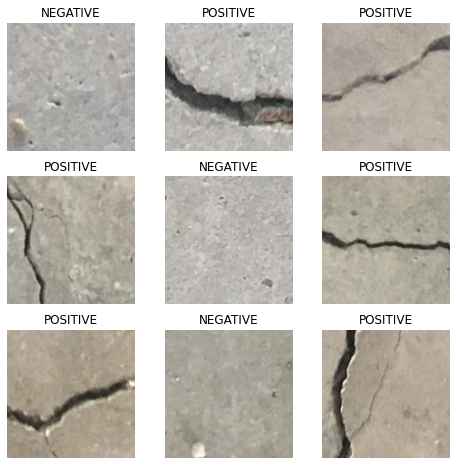

In [8]:
# DATA BEFORE AUGMENTATION
CLASSES = TRAIN_IT.class_names

plt.figure(figsize=(8, 8))
for images, labels in TRAIN_IT.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")

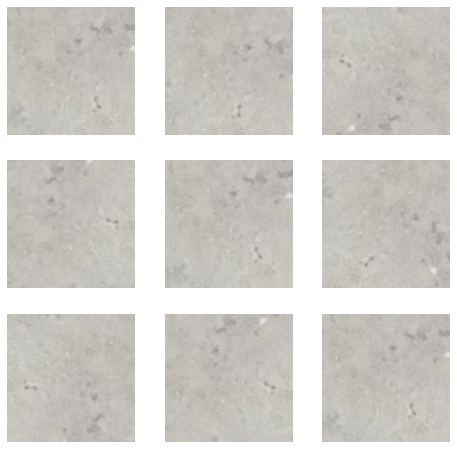

In [9]:
# DATA AFTER AUGMENTATION
for image, _ in TRAIN_IT.take(1):
  plt.figure(figsize=(8, 8))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    aug_img = DATA_AUG(tf.expand_dims(first_image, 0))
    plt.imshow(aug_img[0] / 255)
    plt.axis('off')

### CREATING MODEL

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

TRAIN_IT = TRAIN_IT.prefetch(buffer_size=AUTOTUNE)
VAL_IT = VAL_IT.prefetch(buffer_size=AUTOTUNE)
TEST_IT = TEST_IT.prefetch(buffer_size=AUTOTUNE)

In [11]:
INITIAL_MODEL = tf.keras.applications.inception_v3.InceptionV3(input_shape= INPUT_SHAPE, include_top=False, weights='imagenet')

87916544/87910968 [==============================] - 2s 0us/step


In [12]:
INITIAL_MODEL.trainable = False

In [13]:
INITIAL_MODEL.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [14]:
 pred_layer=tf.keras.layers.Dense(1,activation='sigmoid')

In [15]:
input = tf.keras.Input(shape= INPUT_SHAPE)
x = DATA_AUG(input)
x = tf.keras.applications.inception_v3.preprocess_input(input)
x = INITIAL_MODEL(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D() (x)
x = tf.keras.layers.Dropout(0.3)(x)
output = pred_layer(x)
model = tf.keras.Model(input, output)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits= False),
              metrics=['accuracy','Precision', 'Recall'])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

### TRAINING THE MODEL

In [18]:
epochs = 10
history = model.fit(TRAIN_IT, epochs=epochs, validation_data=VAL_IT)

Epoch 1/10
909/909 [==============================] - 269s 284ms/step - loss: 0.2849 - accuracy: 0.8893 - precision: 0.8804 - recall: 0.9445 - val_loss: 0.0607 - val_accuracy: 0.9901 - val_precision: 0.9933 - val_recall: 0.9912
Epoch 2/10
909/909 [==============================] - 61s 66ms/step - loss: 0.0603 - accuracy: 0.9874 - precision: 0.9921 - recall: 0.9865 - val_loss: 0.0333 - val_accuracy: 0.9929 - val_precision: 0.9944 - val_recall: 0.9946
Epoch 3/10
909/909 [==============================] - 61s 67ms/step - loss: 0.0359 - accuracy: 0.9919 - precision: 0.9946 - recall: 0.9916 - val_loss: 0.0243 - val_accuracy: 0.9940 - val_precision: 0.9954 - val_recall: 0.9953
Epoch 4/10
909/909 [==============================] - 61s 67ms/step - loss: 0.0260 - accuracy: 0.9937 - precision: 0.9958 - recall: 0.9935 - val_loss: 0.0199 - val_accuracy: 0.9944 - val_precision: 0.9958 - val_recall: 0.9954
Epoch 5/10
909/909 [==============================] - 61s 66ms/step - loss: 0.0220 - accuracy:

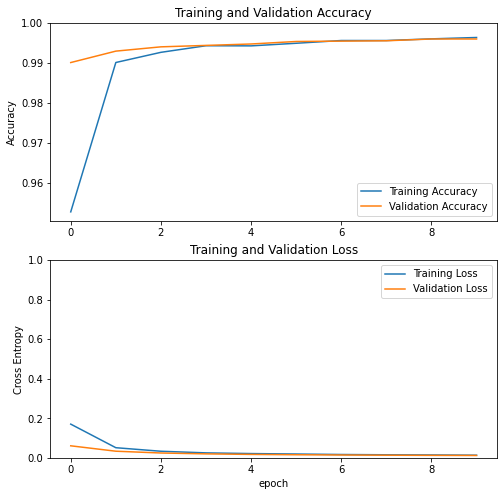

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
INITIAL_MODEL.trainable = True

In [21]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in INITIAL_MODEL.layers[:fine_tune_at]:
  layer.trainable =  False

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits= False), optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate/10),
              metrics=['accuracy','Precision','Recall'])

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [24]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(TRAIN_IT,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=VAL_IT)

Epoch 10/20
909/909 [==============================] - 126s 129ms/step - loss: 0.0087 - accuracy: 0.9974 - precision: 0.9977 - recall: 0.9979 - val_loss: 0.0016 - val_accuracy: 0.9996 - val_precision: 1.0000 - val_recall: 0.9993
Epoch 11/20
909/909 [==============================] - 116s 127ms/step - loss: 0.0027 - accuracy: 0.9993 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.0023 - val_accuracy: 0.9995 - val_precision: 0.9994 - val_recall: 0.9997
Epoch 12/20
909/909 [==============================] - 116s 127ms/step - loss: 0.0010 - accuracy: 0.9997 - precision: 0.9998 - recall: 0.9997 - val_loss: 0.0064 - val_accuracy: 0.9992 - val_precision: 0.9989 - val_recall: 0.9999
Epoch 13/20
909/909 [==============================] - 115s 126ms/step - loss: 5.2407e-04 - accuracy: 0.9999 - precision: 0.9998 - recall: 1.0000 - val_loss: 0.0034 - val_accuracy: 0.9996 - val_precision: 0.9994 - val_recall: 0.9999
Epoch 14/20
909/909 [==============================] - 116s 127ms/step - loss: 1

In [25]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

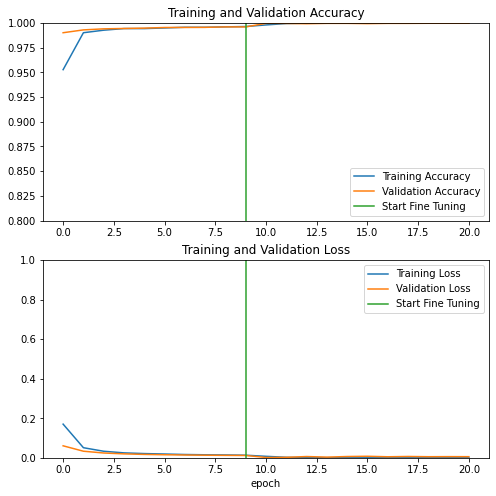

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluating Model

In [27]:
loss, accuracy, precision, recall = model.evaluate(TEST_IT)
print('Test accuracy :', accuracy)
print('Test precision :', precision)
print('Test recall :', recall)

349/349 [==============================] - 74s 206ms/step - loss: 0.0025 - accuracy: 0.9998 - precision: 0.9997 - recall: 1.0000
Test accuracy : 0.9998207092285156
Test precision : 0.999720573425293
Test recall : 1.0


In [28]:
f1_score = (2*precision*recall)/(precision+recall)
print('F1 Score : ', f1_score)

F1 Score :  0.9998602671901162
